In [1]:
import os
import sqlalchemy
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 200)

In [2]:
WORK_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(WORK_DIR, 'participacao-live', 'data')

In [5]:
engine = sqlalchemy.create_engine( "sqlite:///" + os.path.join(DATA_DIR, 'olist.db'))

In [6]:
df = pd.read_sql_table('tb_abt_churn', engine)

In [7]:
df.head()

,dt_ref,seller_city,seller_state,seller_id,avg_review_score,idade_base_dias,idade_base_mes,qtde_dias_utl_venda,qtde_mes_ativacao,prop_ativacao,prop_atraso,avg_tempo_entrega_est,receita_total,avg_vl_venda,avg_vl_venda_mes,avg_vl_venda_mes_ativado,qtde_vendas,qtde_produto,qtde_produto_dst,avg_vl_produto,avg_qtde_produto_venda,qtde_cama_mesa_banho,qtde_beleza_saude,qtde_esporte_lazer,qtde_moveis_decoracao,qtde_informatica_acessorios,qtde_utilidades_domesticas,qtde_relogios_presentes,qtde_telefonia,qtde_ferramentas_jardim,qtde_automotivo,qtde_brinquedos,qtde_cool_stuff,qtde_perfumaria,qtde_bebes,qtde_eletronicos,qtde_papelaria,qtde_fashion_bolsas_e_acessorios,qtde_pet_shop,qtde_moveis_escritorio,qtde_consoles_games,qtde_malas_acessorios,qtde_construcao_ferramentas_construcao,qtde_eletrodomesticos,qtde_instrumentos_musicais,qtde_eletroportateis,qtde_casa_construcao,qtde_livros_interesse_geral,qtde_alimentos,qtde_moveis_sala,qtde_casa_conforto,qtde_bebidas,qtde_audio,qtde_market_place,qtde_construcao_ferramentas_iluminacao,qtde_climatizacao,qtde_moveis_cozinha_area_de_servico_jantar_e_jardim,qtde_alimentos_bebidas,qtde_industria_comercio_e_negocios,qtde_livros_tecnicos,qtde_telefonia_fixa,qtde_fashion_calcados,qtde_eletrodomesticos_2,qtde_construcao_ferramentas_jardim,qtde_agro_industria_e_comercio,qtde_artes,qtde_pcs,qtde_sinalizacao_e_seguranca,qtde_construcao_ferramentas_seguranca,qtde_artigos_de_natal,flag_churn
0,2017-10-01,santo andre,SP,0015a82c2db000af6aaaf3ae2ecb0532,5.000000,3.066481,1,3,1,1.000000,0,33,895.0,895.0,895.00,895.0,1,1,1,895.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-11-01,santo andre,SP,0015a82c2db000af6aaaf3ae2ecb0532,3.666667,34.066481,2,13,2,1.000000,0,26,2685.0,895.0,1342.50,1342.5,3,3,1,895.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2017-12-01,santo andre,SP,0015a82c2db000af6aaaf3ae2ecb0532,3.666667,64.066481,3,43,2,0.666667,0,26,2685.0,895.0,895.00,1342.5,3,3,1,895.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2018-01-01,santo andre,SP,0015a82c2db000af6aaaf3ae2ecb0532,3.666667,95.066481,4,74,2,0.500000,0,26,2685.0,895.0,671.25,1342.5,3,3,1,895.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2018-02-01,santo andre,SP,0015a82c2db000af6aaaf3ae2ecb0532,3.666667,126.066481,5,105,2,0.400000,0,26,2685.0,895.0,537.00,1342.5,3,3,1,895.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
df['dt_ref'].value_counts()

2018-06-01    1858
2018-05-01    1781
2018-04-01    1644
2018-03-01    1589
2018-02-01    1529
2018-01-01    1431
2017-12-01    1380
2017-11-01    1260
2017-10-01    1160
2017-09-01    1080
2017-08-01    1009
2017-07-01     918
2017-06-01     849
2017-05-01     733
2017-04-01     652
Name: dt_ref, dtype: int64

In [9]:
# Filtering the Out of Time Base
df_oot = df.query('dt_ref == "2018-06-01"').copy()

# Filtering the Model Training Base
df_abt = df.query('dt_ref < "2018-06-01"').copy()

### Modelando com Pycaret

In [10]:
#!pip install pycaret

In [11]:
from pycaret.classification import *

In [12]:
to_remove = ['dt_ref', 'seller_city', 'seller_state', 'seller_id']
num_vars  = [col for col in df_abt.columns if col not in to_remove + ['flag_churn']]

In [13]:
ml_setup = setup(data=df_abt, target='flag_churn', train_size=0.8, session_id=1234,
                 ignore_features=to_remove,
                 numeric_features=num_vars, )

 
Setup Succesfully Completed!


,Description,Value
0,session_id,1234
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(17015, 71)"
4,Missing Values,False
5,Numeric Features,66
6,Categorical Features,3
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


### Compare Models

#### O pycaret irá treinar vários modelos via kfold cross-validation. Por padrão ele usa um fold = 10, mas iremos mudar para fold = 5.

In [14]:
compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.826000,0.887600,0.672600,0.750500,0.709200,0.585700
1,Extra Trees Classifier,0.825900,0.885500,0.660000,0.757300,0.705200,0.582500
2,Light Gradient Boosting Machine,0.822800,0.887100,0.670500,0.743200,0.704800,0.578700
3,Random Forest Classifier,0.813000,0.861000,0.608100,0.752100,0.672400,0.543600
4,Gradient Boosting Classifier,0.810400,0.874300,0.642500,0.725500,0.681300,0.547100
5,Extreme Gradient Boosting,0.809100,0.874500,0.638300,0.724500,0.678400,0.543500
6,Logistic Regression,0.801900,0.855800,0.572900,0.740600,0.645800,0.511400
7,Ada Boost Classifier,0.801400,0.862000,0.633900,0.706900,0.668200,0.527100
8,Linear Discriminant Analysis,0.801100,0.863000,0.553800,0.751200,0.637300,0.504600
9,Ridge Classifier,0.799700,0.000000,0.539100,0.756500,0.629400,0.497300


#### Para mostrar todas as funcionalidades do Pycaret, vamos pegar a árvore de decisão

In [16]:
dt_model = create_model(estimator='rf', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8109,0.8559,0.6007,0.7500,0.6671,0.5373
1,0.8175,0.8651,0.6065,0.7662,0.6771,0.5522
2,0.8211,0.8586,0.6119,0.7732,0.6831,0.5608
3,0.8082,0.8639,0.6100,0.7370,0.6675,0.5344
4,0.8075,0.8614,0.6112,0.7343,0.6671,0.5333
Mean,0.8130,0.8610,0.6081,0.7521,0.6724,0.5436
SD,0.0053,0.0034,0.0041,0.0155,0.0066,0.0110


#### Verificando a performance do modelo no conjunto de teste, test_set

In [17]:
predict_model(dt_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Random Forest Classifier,0.809,0.8609,0.5829,0.756,0.6583,0.5288


,avg_review_score,idade_base_dias,qtde_dias_utl_venda,qtde_mes_ativacao,prop_ativacao,prop_atraso,avg_tempo_entrega_est,receita_total,avg_vl_venda,avg_vl_venda_mes,...,qtde_construcao_ferramentas_jardim,qtde_agro_industria_e_comercio,qtde_artes,qtde_pcs,qtde_sinalizacao_e_seguranca,qtde_construcao_ferramentas_seguranca,qtde_artigos_de_natal,flag_churn,Label,Score
0,5.000000,25.312396,25.0,1.0,1.00,0.0,16.0,167.90,167.900000,167.900000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.4
1,4.714286,231.982002,8.0,3.0,0.50,0.0,29.0,300.30,42.900000,50.050000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.2
2,4.750000,128.565058,0.0,5.0,1.00,0.0,20.0,576.30,96.050000,115.260000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.1
3,4.333333,269.456794,100.0,3.0,0.50,0.0,18.0,258.40,43.066667,43.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.8
4,1.000000,5.907662,5.0,1.0,1.00,0.0,19.0,43.35,43.350000,43.350000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3398,4.285714,92.402558,21.0,4.0,1.00,0.0,22.0,1913.89,136.706429,478.472500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.1
3399,3.333333,239.412894,92.0,3.0,0.50,0.0,29.0,767.10,127.850000,127.850000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1.0
3400,4.333333,107.527315,19.0,3.0,0.75,0.0,21.0,88.90,29.633333,22.225000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.2
3401,4.692308,163.867812,1.0,6.0,1.00,0.0,23.0,1708.00,131.384615,284.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0


#### Agora vamos realizar otimização de hiperparâmetros. A função `tune_model` realiza uma random search usando o train_set.

In [19]:
tuned_dt = tune_model('rf', fold=5, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8226,0.8849,0.6647,0.7454,0.7028,0.5770
1,0.8274,0.8891,0.6577,0.7625,0.7062,0.5850
2,0.8277,0.8881,0.6317,0.7799,0.6980,0.5793
3,0.8156,0.8825,0.6589,0.7303,0.6928,0.5615
4,0.8211,0.8884,0.6531,0.7480,0.6973,0.5712
Mean,0.8229,0.8866,0.6532,0.7532,0.6994,0.5748
SD,0.0045,0.0025,0.0114,0.0168,0.0047,0.0080


#### Performance do modelo no test_set

In [20]:
predict_model(tuned_dt)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Random Forest Classifier,0.8184,0.8857,0.6313,0.7533,0.6869,0.5604


,avg_review_score,idade_base_dias,qtde_dias_utl_venda,qtde_mes_ativacao,prop_ativacao,prop_atraso,avg_tempo_entrega_est,receita_total,avg_vl_venda,avg_vl_venda_mes,...,qtde_construcao_ferramentas_jardim,qtde_agro_industria_e_comercio,qtde_artes,qtde_pcs,qtde_sinalizacao_e_seguranca,qtde_construcao_ferramentas_seguranca,qtde_artigos_de_natal,flag_churn,Label,Score
0,5.000000,25.312396,25.0,1.0,1.00,0.0,16.0,167.90,167.900000,167.900000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.3584
1,4.714286,231.982002,8.0,3.0,0.50,0.0,29.0,300.30,42.900000,50.050000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.3148
2,4.750000,128.565058,0.0,5.0,1.00,0.0,20.0,576.30,96.050000,115.260000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.1075
3,4.333333,269.456794,100.0,3.0,0.50,0.0,18.0,258.40,43.066667,43.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.8775
4,1.000000,5.907662,5.0,1.0,1.00,0.0,19.0,43.35,43.350000,43.350000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.4109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3398,4.285714,92.402558,21.0,4.0,1.00,0.0,22.0,1913.89,136.706429,478.472500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.2052
3399,3.333333,239.412894,92.0,3.0,0.50,0.0,29.0,767.10,127.850000,127.850000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.7632
3400,4.333333,107.527315,19.0,3.0,0.75,0.0,21.0,88.90,29.633333,22.225000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.2663
3401,4.692308,163.867812,1.0,6.0,1.00,0.0,23.0,1708.00,131.384615,284.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0300


In [21]:
evaluate_model(tuned_dt)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [22]:
print(tuned_dt)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)


In [23]:
final_dt_tuned = finalize_model(tuned_dt)

In [24]:
save_model(final_dt_tuned, 'random_forest_model')

Transformation Pipeline and Model Succesfully Saved


### Avaliando na base Out of Time

In [27]:
loaded_dt_model = load_model('random_forest_model')

Transformation Pipeline and Model Sucessfully Loaded


In [28]:
print(loaded_dt_model)

[Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True,
                                      features_todrop=['dt_ref', 'seller_city',
                                                       'seller_state',
                                                       'seller_id'],
                                      ml_usecase='classification',
                                      numerical_features=['avg_review_score',
                                                          'idade_base_dias',
                                                          'idade_base_mes',
                                                          'qtde_dias_utl_venda',
                                                          'qtde_mes_ativacao',
                                                          'prop_ativacao',
                                                          'prop_atraso',
   

In [29]:
predictions = predict_model(loaded_dt_model, data=df_oot)

In [30]:
predictions.head()

,dt_ref,seller_city,seller_state,seller_id,avg_review_score,idade_base_dias,idade_base_mes,qtde_dias_utl_venda,qtde_mes_ativacao,prop_ativacao,...,qtde_construcao_ferramentas_jardim,qtde_agro_industria_e_comercio,qtde_artes,qtde_pcs,qtde_sinalizacao_e_seguranca,qtde_construcao_ferramentas_seguranca,qtde_artigos_de_natal,flag_churn,Label,Score
0,2018-06-01,cariacica,ES,001cca7ae9ae17fb1caed9dfb1094831,3.783784,481.197465,17,33,5,0.833333,...,0,0,0,0,0,0,0,0,0,0.2779
1,2018-06-01,franca,SP,002100f778ceb8431b7a1020ff7ab48f,3.964286,259.951215,9,49,5,0.833333,...,0,0,0,0,0,0,0,1,0,0.2910
2,2018-06-01,goiania,GO,003554e2dce176b5555353e4f3555ac8,5.000000,167.700660,6,167,1,0.166667,...,0,0,0,0,0,0,0,1,1,0.9011
3,2018-06-01,ibitinga,SP,004c9cd9d87a3c30c522c48c4fc07416,3.976190,488.894132,17,26,6,1.000000,...,0,0,0,0,0,0,0,1,0,0.1047
4,2018-06-01,guarulhos,SP,00720abe85ba0859807595bbf045a33b,3.944444,124.418947,5,10,5,1.000000,...,0,0,0,0,0,0,0,0,0,0.0285


In [31]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

acc = accuracy_score(predictions['flag_churn'], predictions['Label'])
auc = roc_auc_score(predictions['flag_churn'], predictions['Score'])
recall = recall_score(predictions['flag_churn'], predictions['Label'])
precision = precision_score(predictions['flag_churn'], predictions['Label'])
f1 = f1_score(predictions['flag_churn'], predictions['Label'])

In [32]:
cols   = ['Model', 'Accuracy', 'AUC', 'Recall', 'Prec.', 'F1']
values = ['Decision Tree Classifier', acc, auc, recall, precision, f1]
metrics_oot = pd.DataFrame({tup[0]: [tup[1]] for tup in zip(cols, values)})
metrics_oot

,Model,Accuracy,AUC,Recall,Prec.,F1
0,Decision Tree Classifier,0.798708,0.860913,0.621311,0.726054,0.669611


### Usando o Modelo Vencedor: Catboost

In [33]:
tuned_catboost = tune_model('catboost', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8417,0.8983,0.7171,0.7662,0.7408,0.6271
1,0.8458,0.9009,0.7101,0.7810,0.7439,0.6339
2,0.8490,0.9022,0.7168,0.7854,0.7495,0.6418
3,0.8420,0.8996,0.7322,0.7587,0.7453,0.6308
4,0.8424,0.9003,0.7253,0.7635,0.7439,0.6302
Mean,0.8442,0.9003,0.7203,0.7710,0.7447,0.6328
SD,0.0028,0.0013,0.0077,0.0104,0.0028,0.0050


In [34]:
predict_model(tuned_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.8522,0.9076,0.7197,0.7928,0.7545,0.6491


,avg_review_score,idade_base_dias,qtde_dias_utl_venda,qtde_mes_ativacao,prop_ativacao,prop_atraso,avg_tempo_entrega_est,receita_total,avg_vl_venda,avg_vl_venda_mes,...,qtde_construcao_ferramentas_jardim,qtde_agro_industria_e_comercio,qtde_artes,qtde_pcs,qtde_sinalizacao_e_seguranca,qtde_construcao_ferramentas_seguranca,qtde_artigos_de_natal,flag_churn,Label,Score
0,5.000000,25.312396,25.0,1.0,1.00,0.0,16.0,167.90,167.900000,167.900000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.2493
1,4.714286,231.982002,8.0,3.0,0.50,0.0,29.0,300.30,42.900000,50.050000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0455
2,4.750000,128.565058,0.0,5.0,1.00,0.0,20.0,576.30,96.050000,115.260000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0057
3,4.333333,269.456794,100.0,3.0,0.50,0.0,18.0,258.40,43.066667,43.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9945
4,1.000000,5.907662,5.0,1.0,1.00,0.0,19.0,43.35,43.350000,43.350000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.4066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3398,4.285714,92.402558,21.0,4.0,1.00,0.0,22.0,1913.89,136.706429,478.472500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.4869
3399,3.333333,239.412894,92.0,3.0,0.50,0.0,29.0,767.10,127.850000,127.850000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.5681
3400,4.333333,107.527315,19.0,3.0,0.75,0.0,21.0,88.90,29.633333,22.225000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.1385
3401,4.692308,163.867812,1.0,6.0,1.00,0.0,23.0,1708.00,131.384615,284.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0012


In [36]:
#evaluate_model(tuned_catboost)

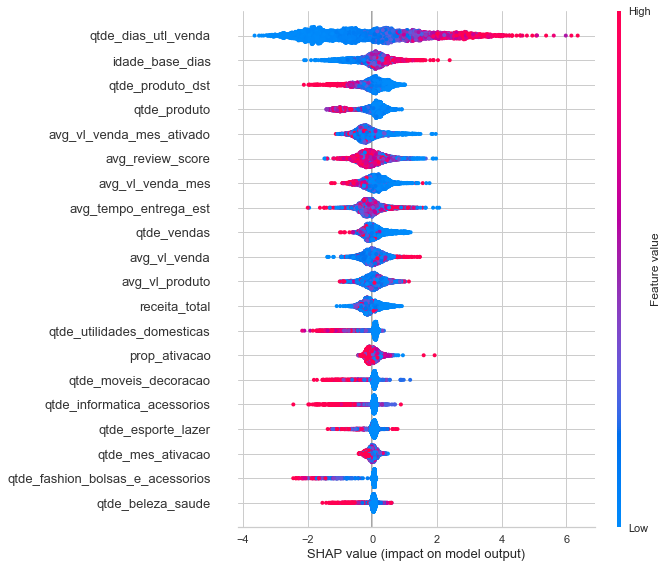

In [37]:
interpret_model(tuned_catboost)

##### As variáveis aparecem em ordem de importância de cima para baixo.

##### Quanto mais a direita de 0, maior a chance de churn (1). Quanto mais a esquerda, menor a chance de Churn (0).


##### Interpretação da primeira variável:

`Quanto maior a recência do seller, maior a probabilidade dele dar churn.`

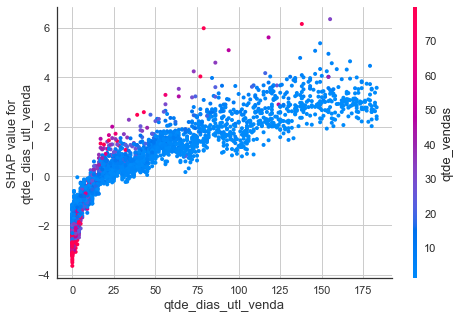

In [38]:
interpret_model(tuned_catboost, plot='correlation', feature='qtde_dias_utl_venda')

Pessoas que possuem alta recência e venderam poucos produtos são mais propensas a dar Churn.

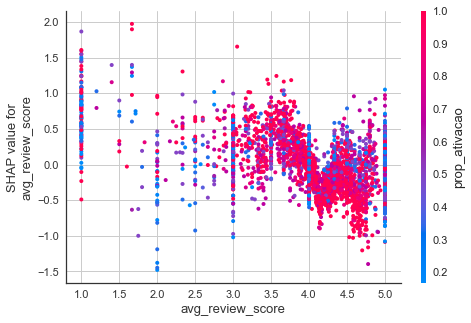

In [39]:
interpret_model(tuned_catboost, plot='correlation', feature='avg_review_score')

Quanto maior o review médio e a proporção de ativação, maior a chance do seller continuar vendendo nos próximos 3 meses.

In [51]:
#interpret_model(tuned_catboost, plot='reason', observation=0)

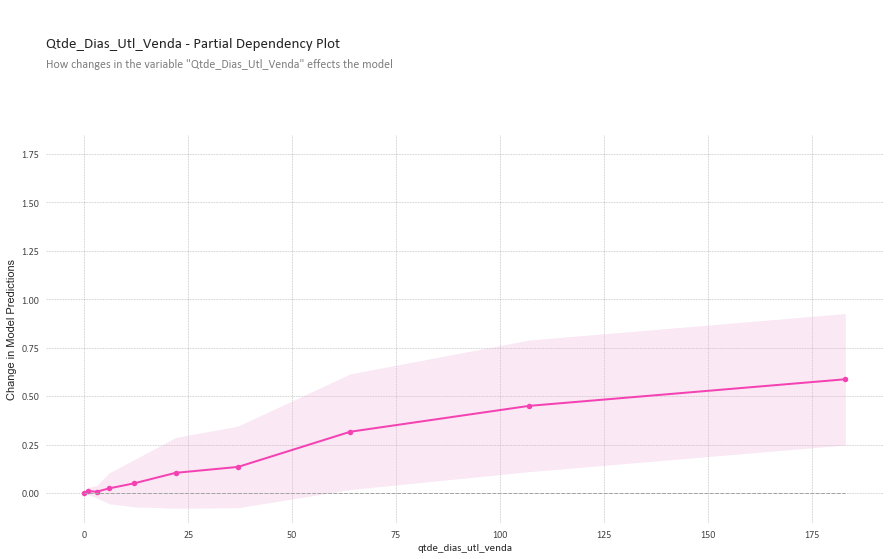

In [25]:
from pdpbox import pdp
import matplotlib.pyplot as plt

#plotar as linhas
def _plot_pdp(feature, pdp_color, fill_color):
    plot_params = {
        'title': feature.title() + ' - Partial Dependency Plot',
        'title_fontsize': 15,
        'subtitle': 'How changes in the variable "%s" effects the model' % feature.title(),
        'subtitle_fontsize': 12,
        'font_family': 'Calibri',
        'xticks_rotation': 0,
        'line_cmap': 'cool',
        'zero_color': '#a2a5a0',
        'zero_linewidth': 1.0,
        'pdp_linewidth': 2.0,
        'fill_alpha': 0.25,
        'markersize': 5.5,
        'pdp_hl_color': 'green',
        'pdp_color': pdp_color,
        'fill_color': fill_color,

    }
    pdp_goals = pdp.pdp_isolate(model=tuned_catboost, dataset=ml_setup[3], model_features=ml_setup[3].columns, feature=feature)
    pdp.pdp_plot(pdp_goals, feature, plot_params = plot_params)
    plt.ylabel("Change in Model Predictions");
    plt.show();
    
cols = ml_setup[3].columns.tolist()

_plot_pdp('qtde_dias_utl_venda', "#f442b3", "#efaad6")

`Acima de 0`: Churn

`Abaixo de 0`: Não Churn

In [27]:
final_catboost = finalize_model(tuned_catboost)

In [28]:
predictions = predict_model(final_catboost, data=df_oot)

In [31]:
acc = accuracy_score(predictions['flag_churn'], predictions['Label'])
auc = roc_auc_score(predictions['flag_churn'], predictions['Score'])
recall = recall_score(predictions['flag_churn'], predictions['Label'])
precision = precision_score(predictions['flag_churn'], predictions['Label'])
f1 = f1_score(predictions['flag_churn'], predictions['Label'])

In [32]:
cols   = ['Model', 'Accuracy', 'AUC', 'Recall', 'Prec.', 'F1']
values = ['Catboost Classifier', acc, auc, recall, precision, f1]
metrics_oot = pd.DataFrame({tup[0]: [tup[1]] for tup in zip(cols, values)})
metrics_oot

,Model,Accuracy,AUC,Recall,Prec.,F1
0,Catboost Classifier,0.81916,0.868382,0.681967,0.74552,0.712329
